In [ ]:
!pip install shap catboost -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/krasnodar_hack/cian_parsing_result_sale_1_100_krasnodar_18_Feb_2023_03_00_53_912228.csv', sep=';')
df2 = pd.read_csv('/content/drive/MyDrive/krasnodar_hack/cian_parsing_result_sale_50_200_krasnodar_17_Feb_2023_16_32_25_653503.csv', sep=';')

In [ ]:
df = pd.concat([df1, df2])

In [ ]:
df = df.drop_duplicates()
df = df[df['living_meters'] > 10]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1004 entries, 0 to 131
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   author                1004 non-null   object 
 1   author_type           1004 non-null   object 
 2   link                  1004 non-null   object 
 3   city                  1004 non-null   object 
 4   deal_type             1004 non-null   object 
 5   accommodation_type    1004 non-null   object 
 6   floor                 1004 non-null   int64  
 7   floors_count          1004 non-null   int64  
 8   rooms_count           1004 non-null   int64  
 9   total_meters          1004 non-null   float64
 10  price_per_m2          1004 non-null   int64  
 11  price                 1004 non-null   int64  
 12  year_of_construction  1004 non-null   int64  
 13  living_meters         1004 non-null   float64
 14  kitchen_meters        1004 non-null   float64
 15  phone                 

In [ ]:
df = df.drop(columns=['author', 'author_type', 'city', 'deal_type', 'accommodation_type', 'floors_count', 'price_per_m2', 'phone', 'district', 'street',
       'underground', 'residential_complex'])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


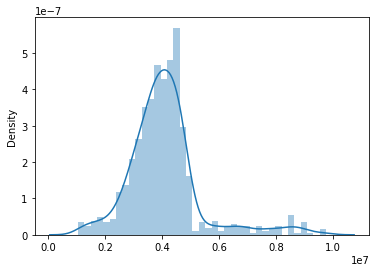

In [ ]:
import seaborn as sns
sns.distplot(df[(df['price'] > 1000000) & (df['price'] < 10000000)]['price'].values)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


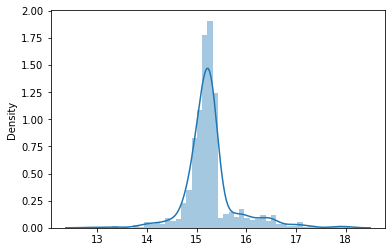

In [ ]:
sns.distplot(np.log(df['price'].values))


In [ ]:
df = df[(df['price'] > 1000000) & (df['price'] < 10000000)]

In [ ]:
1.050000e+06

1050000.0

In [ ]:
df['price'].describe()

count    9.210000e+02
mean     4.081383e+06
std      1.286029e+06
min      1.050000e+06
25%      3.400000e+06
50%      3.980000e+06
75%      4.500000e+06
max      9.750000e+06
Name: price, dtype: float64

In [ ]:
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostRegressor, Pool

In [ ]:
regression_params = dict(
    iterations=5000, 
    learning_rate=0.01,
    verbose=100,
    early_stopping_rounds=500,
    loss_function='RMSE',
    eval_metric='MAE',
    task_type='CPU',
)

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0xBACED)

models = []
preds = []
data = []
for fold, (train_index, val_index) in enumerate(kfold.split(df, df['price'])):
    df_train = df.iloc[train_index]
    df_val = df.iloc[val_index]

    X = df_train.drop(columns=['price', 'link'])
    y = np.log(df_train['price'].values)

    X_val = df_val.drop(columns=['price', 'link'])
    y_val = np.log(df_val['price'].values)

    model = CatBoostRegressor(**regression_params).fit(X, y, eval_set=(X_val, y_val))
    preds.append(np.exp(model.predict(X_val)))
    data.append(df_val)

    models.append(model)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


0:	learn: 0.2087847	test: 0.2202941	best: 0.2202941 (0)	total: 4.76ms	remaining: 23.8s
100:	learn: 0.1821797	test: 0.2034064	best: 0.2034064 (100)	total: 101ms	remaining: 4.89s
200:	learn: 0.1729615	test: 0.2031829	best: 0.2026452 (132)	total: 233ms	remaining: 5.57s
300:	learn: 0.1675100	test: 0.2046471	best: 0.2026452 (132)	total: 344ms	remaining: 5.37s
400:	learn: 0.1635192	test: 0.2059701	best: 0.2026452 (132)	total: 441ms	remaining: 5.05s
500:	learn: 0.1599954	test: 0.2067372	best: 0.2026452 (132)	total: 558ms	remaining: 5.01s
600:	learn: 0.1564030	test: 0.2074788	best: 0.2026452 (132)	total: 663ms	remaining: 4.85s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2026452004
bestIteration = 132

Shrink model to first 133 iterations.
0:	learn: 0.2081645	test: 0.2234853	best: 0.2234853 (0)	total: 1.06ms	remaining: 5.32s
100:	learn: 0.1830416	test: 0.1983601	best: 0.1983601 (100)	total: 89.7ms	remaining: 4.35s
200:	learn: 0.1764459	test: 0.1906699	best: 0.1906699 (2

In [ ]:
import pickle 

with open('models_vtorichka.pkl', 'wb') as f:
    pickle.dump(models, f)

In [ ]:
import uuid

In [ ]:
df['id'] = [str(uuid.uuid4()) for i in range(df.shape[0])]

<ipython-input-66-26f511121cc1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id'] = [str(uuid.uuid4()) for i in range(df.shape[0])]


In [ ]:
full_data = pd.concat(data)

In [ ]:
full_data['pred_price'] = np.concatenate(np.array(preds))

<ipython-input-98-34150432fa31>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  full_data['pred_price'] = np.concatenate(np.array(preds))


In [ ]:
full_data['diff'] = (full_data['pred_price']-full_data['price'])/(full_data['price']*100)*10000

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


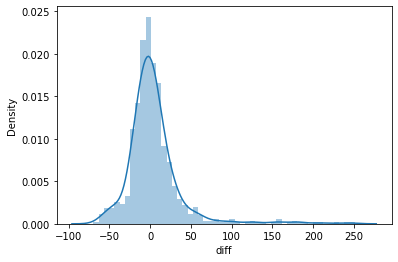

In [ ]:
sns.distplot(full_data['diff'])

In [ ]:
full_data = full_data[(full_data['diff'] > -40) & (full_data['diff'] < 40)]

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


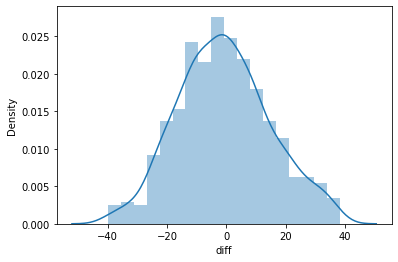

In [ ]:
sns.distplot(full_data['diff'])

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
1-mean_absolute_percentage_error(full_data['price'], full_data['pred_price'])

0.8755430954272614

In [ ]:
marker = []
for diff in full_data['diff']:
    if diff >= 3:
        marker.append('overpriced')
    elif diff <= -3:
        marker.append('underpriced')
    else:
        marker.append('riskey')

In [ ]:
full_data['marker'] = marker

<ipython-input-113-c38300c6d6bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data['marker'] = marker


In [ ]:
full_data = full_data[~full_data['marker'].isin(['riskey'])]

In [ ]:
full_data.to_csv('vtorichka_final.csv', index=False)

In [ ]:
full_data

,link,floor,rooms_count,total_meters,price,year_of_construction,living_meters,kitchen_meters,pred_price,diff,marker
1,https://krasnodar.cian.ru/sale/flat/279661943/,20,1,43.0,4950000,2021,18.2,14.8,4.283516e+06,-13.464333,underpriced
20,https://krasnodar.cian.ru/sale/flat/283765339/,5,1,40.0,4100000,2006,22.9,9.7,3.961314e+06,-3.382591,underpriced
58,https://krasnodar.cian.ru/sale/flat/280008092/,10,2,61.2,7150000,2017,11.5,11.2,4.384590e+06,-38.677063,underpriced
72,https://krasnodar.cian.ru/sale/flat/283282828/,6,2,63.4,4530000,2010,31.5,16.8,4.974593e+06,9.814404,overpriced
73,https://krasnodar.cian.ru/sale/flat/283383338/,6,1,41.5,3500000,2017,19.7,10.8,4.035056e+06,15.287324,overpriced
...,...,...,...,...,...,...,...,...,...,...,...
104,https://krasnodar.cian.ru/sale/flat/277400873/,5,2,50.0,4900000,1965,28.0,-1.0,4.098767e+06,-16.351694,underpriced
106,https://krasnodar.cian.ru/sale/flat/279004402/,3,1,39.1,4900000,2017,18.0,10.0,3.849727e+06,-21.434151,underpriced
112,https://krasnodar.cian.ru/sale/flat/280209896/,15,1,40.5,4900000,2018,16.0,13.0,4.065052e+06,-17.039765,underpriced
118,https://krasnodar.cian.ru/sale/flat/273790417/,2,1,41.7,4900000,2012,22.0,10.0,3.836344e+06,-21.707273,underpriced
